# Motivation
This notebook analyses the spreadsheet containing information on the reversals. This spreadsheet collects different features on the trades in an attempt of creating a binary classifier, this classifier will learn from the data collected and will predict the value of the `outcome` variable, which can be success of failre

# Data
The data has been collected in an spreadsheet containing trades both simulated and real. And the different trades have been classified into three types: continuation, counter and ranging. The independent variables gathered for each trade type are:
## Counter trades
* id	id used in the screenshot folder to identify this record
* start	start of this trade
* timeframe	in the format 2D,D,H12,H8
* entry	price
* outcome	S=success;F=failure;B=breakeven
* ext_outcome. S=success;F=failure;B=breakeven
* RSI bounces. number of RSI bounces ocurring in the trend before entry
* No of candles. How many candles before occurred the bounce, from the entry of trade to the first bounce (without counting the entry candle)
* entry on RSI. Was the entry candle on RSI?
* length of trend. lenght of the preceding trend in number of candles. The valley before the continuation is not included in the count
* bounce length. Length in number of candles for each of the bounces (in the order from the most recent to the oldest)
* bounce pips. Length from the horizontal line defined by IC until the highest point of the bounce (considering wicks also)
* inn_bounce. Number of candles of the inner bounce (see screenshots below)
* indecission	Number of candles the price stays in S/R, without considering the bounce and only considering the candles pre/post bounce
* divergence. Does the price has divergence with the RSI indicator?
* retraced.	Only relevant for outcome=F, how many pips from the S/L the trade reversed?. If n.a., then it means that the trade did not reversed last time that the price was below/above this level assuming that a possible counter could happen

## Dependencies

In [978]:
import pandas as pd
import numpy as np
import pdb
import re
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.metrics import confusion_matrix,precision_score
from sklearn.model_selection import train_test_split

%matplotlib inline

# Counter trades

First, let's create a function to read-in a .csv file containing the data andstore it in a dataframe:

In [979]:
def read_tradedata(tradefile,sep,na_values):
    '''
    Parameters
    ----------
    tradefile : str, required
                Path to file containing the trade data
    sep : str, optionsl
          Field separator used in the file. i.e. ',' (comma separated values), '\t' (tab-separated values)
    na_values : list, optional
                Additional list of strings to recognize as NA/NaN. i.e. ['n.a.']
    
    Returns
    -------
    A Pandas dataframe
    '''
    DF=pd.read_csv(tradefile,sep=sep,na_values=na_values)
    
    return DF

contDF=read_tradedata('/Users/ernesto/Downloads/Screenshot_analysis_counter.csv',sep=",",na_values=["n.a.","n.a"])

contDF.shape

FileNotFoundError: File b'/Users/ernesto/Downloads/Screenshot_analysis_counter.csv' does not exist

And some information about contDF:

In [ ]:
contDF.info()

* Conversion to right types<br>
Let's convert now the `start` and `last time` variables to DateTime

In [ ]:
contDF['start']= pd.to_datetime(contDF['start'])
contDF['last time']= pd.to_datetime(contDF['last time'])

## Cleaning the n.a. values
The following predictors have n.a. values and the strategy I will follow will depend on each case:

* No of candles (will replace the n.a. by 0)

In [980]:
contDF["No of candles"].fillna(0, inplace=True)

* Bounce length (will replace the n.a. by 0)

In [981]:
contDF["bounce length"].fillna(0, inplace=True)

## Transforming

In [982]:
transl_dict={ 
        'S':1,
        'F':0, 
        True:1, 
        False:0
    }
def digit_binary(x,transl_dict,name):
    '''
    This function will replace the values in categorical
    binary variables by 1 and 0
    
    Parameters
    ----------
    transl_dict: dict
                 Keys will be the old categorical names and Values
                 will be 1 and 0. For example:
                 transl_dict={ 
                            'S':1,
                            'F':0, 
                            True:1, 
                            False:0
                            }
    name: str
          Name of the column to modify
        
    Returns
    -------
    The new label for the categorical variable
    '''
    
    return transl_dict[x[name]]

contDF['ext_outcome']=contDF.apply(digit_binary,axis=1,transl_dict=transl_dict, name='ext_outcome')
contDF['Candle +1 against trade']=contDF.apply(digit_binary,axis=1,transl_dict=transl_dict, name='Candle +1 against trade')
contDF['entry on RSI']=contDF.apply(digit_binary,axis=1,transl_dict=transl_dict, name='entry on RSI')
contDF['strong trend']=contDF.apply(digit_binary,axis=1,transl_dict=transl_dict, name='strong trend')

## Initial exploration of the data

First things first, let's examine if we have a significant number of records per category of the dependent variable (outcome in this case), since it is really very important to have enough records to establish solid conclusions

In [983]:
outcome_ix=5 # 4=outcome and 5= ext_outcome
outcome_lab="ext_outcome"
contDF.iloc[:,outcome_ix].value_counts()

1    57
0    55
Name: ext_outcome, dtype: int64

For now I am not going to consider the trades having an outcome of 'B'. So, let's remove them from the dataframe:

In [984]:
contDF=contDF[contDF.outcome != 'B']

### Candle +1 against trade
This variable is True when the IC+1 is against the trade. I will here analyze the influence of this variable on the outcome

Let's create a contigency table analysing the relationship between these 2 variables:

In [985]:
div_class=pd.crosstab(contDF.iloc[:,outcome_ix], contDF['Candle +1 against trade'],margins=True)
print(div_class)

Candle +1 against trade   0   1  All
ext_outcome                         
0                        35  20   55
1                        42  15   57
All                      77  35  112


It's is easier to visualize the relationship if we calculate the percentages:

In [986]:
propCp1=(div_class/div_class.loc["All"])*100
print(propCp1)

Candle +1 against trade           0           1         All
ext_outcome                                                
0                         45.454545   57.142857   49.107143
1                         54.545455   42.857143   50.892857
All                      100.000000  100.000000  100.000000


* Conclusion <br>
Within the trades with IC+1 against the trade there are {{'%.1f' % propCp1.iloc[0, 1]}}% of failures and {{'%.1f' % propCp1.iloc[1, 1]}}% of successes<br>
Within the trades with IC+1 in favour of the trade there are {{'%.1f' % propCp1.iloc[0, 0]}}% of failures and {{'%.1f' % propCp1.iloc[1, 0]}}% of successes

###  RSI bounces
Let's examine if there is a correlation between the number of bounces and the outcome of the trade

As an initial exploration I will create a boxplot displaying the data

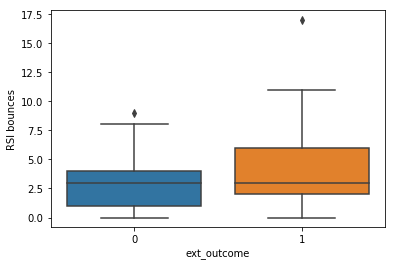

In [987]:
ax = sns.boxplot(x=outcome_lab, y="RSI bounces", data=contDF)

* Mean for each category

In [988]:
contDF.groupby(outcome_lab).agg({'RSI bounces': 'mean'})

,RSI bounces
ext_outcome,
0,3.054545
1,4.228070


* Median for each category

In [989]:
medianBounce=contDF.groupby(outcome_lab).agg({'RSI bounces': 'median'})
print(medianBounce)

             RSI bounces
ext_outcome             
0                      3
1                      3


* Conclusion <br>
The median number of bounces for successful trades is {{'%.0f' % medianBounce.iloc[1,0]}}<br>
The median number of bounces for failed trades is {{'%.0f' % medianBounce.iloc[0,0]}}<br>

* Distribution of the number of bounces<br>
For this particular task I will create a count plot in order to plot the RSI bounces for both the successful and the failed trades

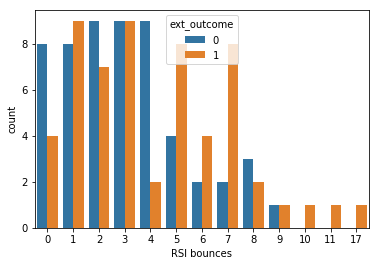

In [990]:
ax = sns.countplot(x="RSI bounces",hue=outcome_lab, data=contDF)

Now, let's calculate the normalized number of bounces, as the 2 categories of the outcome variables are imbalanced

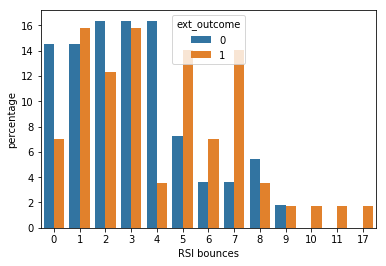

In [991]:
contDF_counts = (contDF.groupby([outcome_lab])['RSI bounces']
                  .value_counts(normalize=True)
                  .rename('percentage')
                  .mul(100)
                  .reset_index()
                  .sort_values('RSI bounces'))

p = sns.barplot(x="RSI bounces", y="percentage", hue=outcome_lab, data=contDF_counts)

* Conclusion<br>
The ideal situation for having a S trade is to have 5 or more bounces

### retraced
This integer variable represents the number of pips from the S/L from where the failing trade retraced and hitted the target. Let's start analyzing the number of trades that retraced:

In [992]:
len(contDF[contDF.retraced.notnull()])

30

Now, let's examine the distribution of the data:

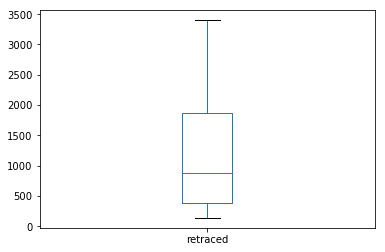

In [993]:
ret=contDF[contDF.retraced.notnull()].retraced.astype(int)
ret.plot(kind="box")

In [994]:
print(ret.describe())

count      30.000000
mean     1211.633333
std       911.267911
min       140.000000
25%       390.750000
50%       876.500000
75%      1863.750000
max      3400.000000
Name: retraced, dtype: float64


### No of candles
This variable represents the number of candles since the beginning of the trade until the first RSI bounce. I am going compare the distribution of this variable depending on the `outcome` variable.<br>

As an initial exploration I will create a boxplot displaying the data:

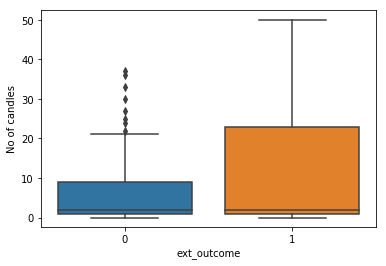

In [995]:
ax = sns.boxplot(x=outcome_lab, y="No of candles", data=contDF)

* Mean for each category

In [996]:
contDF.groupby(outcome_lab).agg({'No of candles': 'mean'})

,No of candles
ext_outcome,
0,7.254545
1,11.228070


* Median for each category

In [997]:
contDF.groupby(outcome_lab).agg({'No of candles': 'median'})

,No of candles
ext_outcome,
0,2.0
1,2.0


Let's analyze the distribution with a histogram

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11ec53668>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11e090630>], dtype=object)

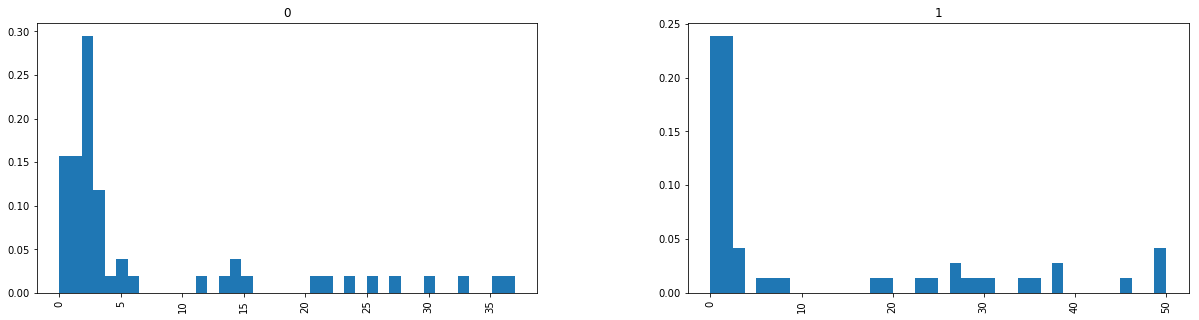

In [998]:
contDF['No of candles'].hist(by=contDF[outcome_lab],figsize=(20,5),bins=40,normed=True)

### entry on RSI
This boolean variable will be True if the entry of the trade is in oversold/overbought RSI
Firs, let's see the counts for each category of the variable

In [999]:
contDF['entry on RSI'].value_counts()

0    95
1    17
Name: entry on RSI, dtype: int64

Let's compare the proportions for this variable between the 2 categories of the `outcome` variable

In [1000]:
div_class=pd.crosstab(contDF.iloc[:,outcome_ix], contDF['entry on RSI'],margins=True)
print(div_class)

entry on RSI   0   1  All
ext_outcome              
0             40  15   55
1             55   2   57
All           95  17  112


It's is easier to visualize the relationship if we calculate the percentages:

In [1001]:
prop=(div_class/div_class.loc["All"])*100
print(prop)

entry on RSI           0           1         All
ext_outcome                                     
0              42.105263   88.235294   49.107143
1              57.894737   11.764706   50.892857
All           100.000000  100.000000  100.000000


* Conclusion <br>
Within the trades having entry on RSI there are {{'%.1f' % prop.iloc[0, 1]}}% of failures and {{'%.1f' % prop.iloc[1, 1]}}% of successes<br>
Within the trades not having an entry on RSI there are {{'%.1f' % prop.iloc[0, 0]}}% of failures and {{'%.1f' % prop.iloc[1, 0]}}% of successes

### length of trend
This quantitative discrete variable measures the length of the trade measured in term of the number of candles. Let's start comparing the distribution of this variable for the different categories of the `outcome` variable

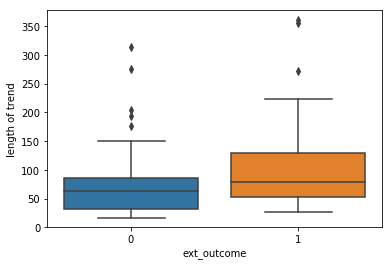

In [1002]:
ax = sns.boxplot(x=outcome_lab, y="length of trend", data=contDF)

(0, 100)

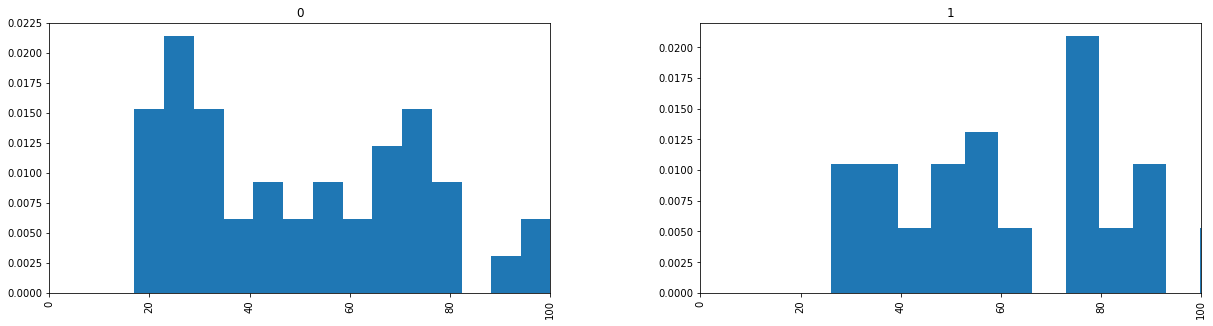

In [1003]:
axList=contDF['length of trend'].hist(by=contDF[outcome_lab],figsize=(20,5),bins=50,normed=True)

axList[0].set_xlim((0,100))
axList[1].set_xlim((0,100))

* Mean for each category

In [1004]:
contDF.groupby(outcome_lab).agg({'length of trend': 'mean'})

,length of trend
ext_outcome,
0,75.109091
1,101.298246


* Median for each category

In [1005]:
contDF.groupby(outcome_lab).agg({'length of trend': 'median'})

,length of trend
ext_outcome,
0,63
1,79


### indecission
Integer variable representing the number of candles the price stays in S/R, without considering the bounce and only considering the candles pre/post bounce. Let's start comparing the distribution of this variable for the different categories of the `outcome` variable

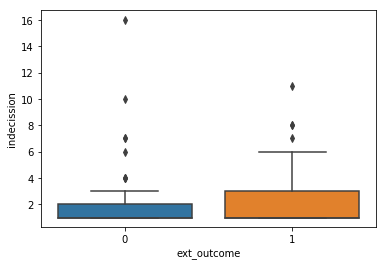

In [1006]:
ax = sns.boxplot(x=outcome_lab, y="indecission", data=contDF)

* Mean for each category

In [1007]:
contDF.groupby(outcome_lab).agg({'indecission': 'mean'})

,indecission
ext_outcome,
0,2.254545
1,2.350877


* Median for each category

In [1008]:
contDF.groupby(outcome_lab).agg({'indecission': 'median'})

,indecission
ext_outcome,
0,1
1,1


* Histogram

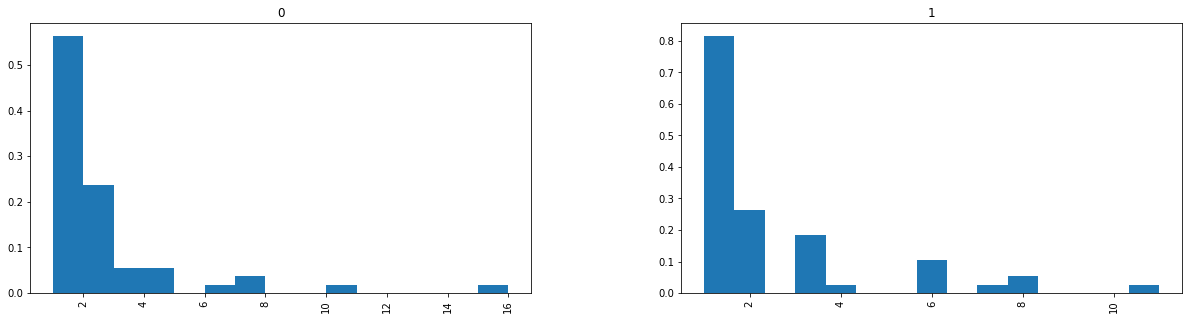

In [1009]:
axList=contDF['indecission'].hist(by=contDF[outcome_lab],figsize=(20,5),bins=15,normed=True)

### Divergence
Boolean that is 1 when the trade presents Divergence, 0 otherwise

Let's compare the proportions for this variable between the 2 categories of the `outcome` variable

In [1010]:
div_class=pd.crosstab(contDF.iloc[:,outcome_ix], contDF['divergence'],margins=True)
print(div_class)

divergence   False  True  All
ext_outcome                  
0               46     9   55
1               26    31   57
All             72    40  112


It's is easier to visualize the relationship if we calculate the percentages:

In [1011]:
propStrength=(div_class/div_class.loc["All"])*100
print(propStrength)

divergence        False   True         All
ext_outcome                               
0             63.888889   22.5   49.107143
1             36.111111   77.5   50.892857
All          100.000000  100.0  100.000000


### Strong trend
Boolean that is 1 when trend is strong, 0 otherwise.

Let's compare the proportions for this variable between the 2 categories of the `outcome` variable

In [1012]:
div_class=pd.crosstab(contDF.iloc[:,outcome_ix], contDF['strong trend'],margins=True)
print(div_class)

strong trend   0   1  All
ext_outcome              
0             34  21   55
1             51   6   57
All           85  27  112


It's is easier to visualize the relationship if we calculate the percentages:

In [1013]:
propStrength=(div_class/div_class.loc["All"])*100
print(propStrength)

strong trend      0           1         All
ext_outcome                                
0              40.0   77.777778   49.107143
1              60.0   22.222222   50.892857
All           100.0  100.000000  100.000000


* Conclusion <br>
Within the trades trending strongly there are {{'%.1f' % propStrength.iloc[0, 1]}}% of failures and {{'%.1f' % propStrength.iloc[1, 1]}}% of successes<br>
Within the trades not trending strongly there are {{'%.1f' % propStrength.iloc[0, 0]}}% of failures and {{'%.1f' % propStrength.iloc[1, 0]}}% of successes

### bounce length
This variable is a comma separated list of integers representing how wide (in number of candles) each of the RSI bounces is. This variable requires a little bit of preprocessing, and I will write a function that calculates the total length (in number of candles) by adding the length of each of the bounces

In [1014]:
def sum_lengths(x):
    '''
    Function to calculate the sum (in number of candles)
    of all the RSI bounces
    
    Parameters
    ----------
    x = string with a comma separated list of numbers
        i.e. 1,4,2,3
        
    Returns
    -------
    An integer representing the total bounce length
    '''
    
    return sum([int(i) for i in x.split(",")])
    

And I will apply the `sum_lengths` function and put the results in a new column named `sum_bounces`

In [1015]:
contDF['sum_bounces']=contDF['bounce length'].astype(str).apply(sum_lengths)

Now, I will plot the distribution of this new variable on each `outcome`category:

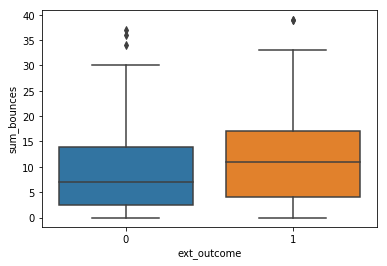

In [1016]:
ax = sns.boxplot(x=outcome_lab, y="sum_bounces", data=contDF)

* Mean for each category

In [1017]:
contDF.groupby(outcome_lab).agg({'sum_bounces': 'mean'})

,sum_bounces
ext_outcome,
0,9.690909
1,12.052632


* Median for each category

In [1018]:
contDF.groupby(outcome_lab).agg({'sum_bounces': 'median'})

,sum_bounces
ext_outcome,
0,7
1,11


* Histogram

(0, 25)

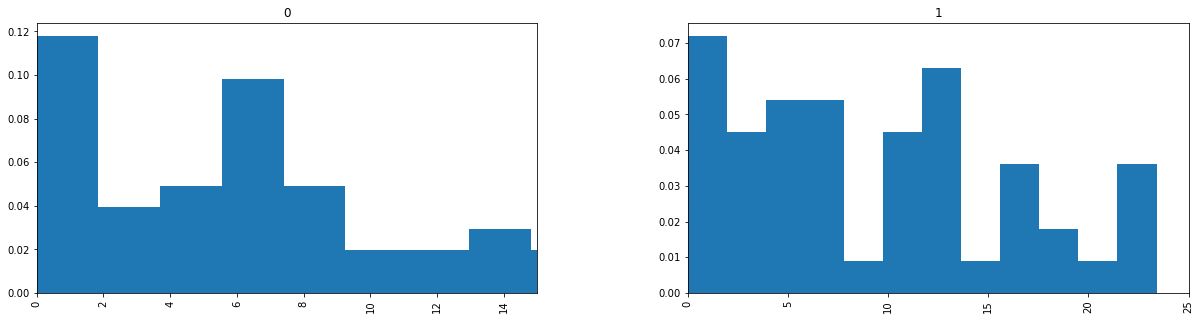

In [1019]:
axList=contDF['sum_bounces'].hist(by=contDF[outcome_lab],figsize=(20,5),bins=20,normed=True)

axList[0].set_xlim((0,15))
axList[1].set_xlim((0,25))

### bounces
This quantitative discrete variable is used for representing the number of times the price has tested this level. Let's start comparing the distribution of this variable for the different categories of the `outcome` variable.

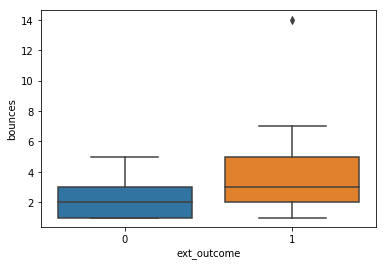

In [1020]:
ax = sns.boxplot(x=outcome_lab, y="bounces", data=contDF)

* Mean for each category

In [1021]:
contDF.groupby(outcome_lab).agg({'bounces': 'mean'})

,bounces
ext_outcome,
0,2.290909
1,3.614035


* Median for each category

In [1022]:
contDF.groupby(outcome_lab).agg({'bounces': 'median'})

,bounces
ext_outcome,
0,2
1,3


### Stretches
Analysis of the different stretches angles and the characteristics of each stretch. First let's calculate the average angle considering all the stretches

#### avg angle

In [1023]:
def avg_angle(x):
    '''
    Function to calculate the average angle for all the
    streches
    
    Parameters
    ----------
    x = string with a comma separated list of numbers
        i.e. 1,4,2,3
        
    Returns
    -------
    A float representing the average angle
    '''
    l=[int(i) for i in x.split(",")]
    mean=sum(l)/len(l)
    return mean

In [1024]:
contDF['avg_angle']=contDF['stretches'].astype(str).apply(avg_angle)

Let's examine the avg angle depending on the outcome variable:

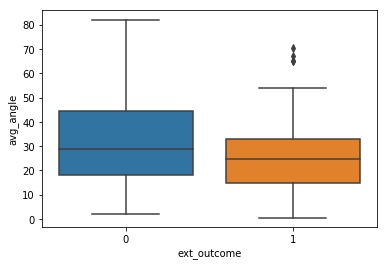

In [1025]:
ax = sns.boxplot(x=outcome_lab, y="avg_angle", data=contDF)

* Mean for each category

In [1026]:
contDF.groupby(outcome_lab).agg({'avg_angle': 'mean'})

,avg_angle
ext_outcome,
0,32.668911
1,26.751897


* Median for each category

In [1027]:
contDF.groupby(outcome_lab).agg({'avg_angle': 'median'})

,avg_angle
ext_outcome,
0,28.666667
1,24.600000


#### Number of stretches

In [1028]:
def number_of_stretches(x):
    '''
    Function to calculate the number of streches
    
    Parameters
    ----------
    x = string with a comma separated list of numbers
        i.e. 1,4,2,3
        
    Returns
    -------
    An integeger
    '''
    
    return len([int(i) for i in x.split(",")])

In [1029]:
contDF['no_stretches']=contDF['stretches'].astype(str).apply(number_of_stretches)

Let's examine the number of stretches depending on the outcome variable:

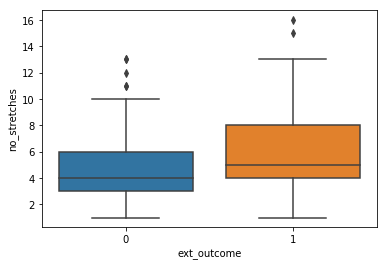

In [1030]:
ax = sns.boxplot(x=outcome_lab, y="no_stretches", data=contDF)

* Mean for each category

In [1031]:
contDF.groupby(outcome_lab).agg({'no_stretches': 'mean'})

,no_stretches
ext_outcome,
0,5.072727
1,6.421053


* Median for each category

In [1032]:
contDF.groupby(outcome_lab).agg({'no_stretches': 'median'})

,no_stretches
ext_outcome,
0,4
1,5


#### Last stretch
This derived variable will represent the angle of the last strech in the trend

In [1033]:
def last_stretch(x):
    '''
    Function to calculate the angle of the last strech
    
    Parameters
    ----------
    x = string with a comma separated list of numbers
        i.e. 1,4,2,3
        
    Returns
    -------
    A float
    '''
    
    l=[int(i) for i in x.split(",")]
    
    return l[len(l)-1]

In [1034]:
contDF['last_stretch']=contDF['stretches'].astype(str).apply(last_stretch)

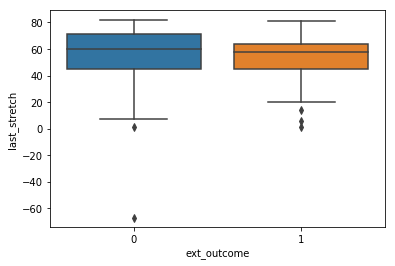

In [1035]:
ax = sns.boxplot(x=outcome_lab, y="last_stretch", data=contDF)

* Mean for each category

In [1036]:
contDF.groupby(outcome_lab).agg({'last_stretch': 'mean'})

,last_stretch
ext_outcome,
0,53.836364
1,54.438596


* Median for each category

In [1037]:
contDF.groupby(outcome_lab).agg({'last_stretch': 'median'})

,last_stretch
ext_outcome,
0,60
1,58


### last time
This datetime variable represents the last time the price was over/below the entry price level. The first to do is to create a new datetime variable representing the difference (in days) between the entry datetime (start column) and the last time datetime.

In [1038]:
contDF['diff']=(contDF['start']-contDF['last time'])

In [1039]:
contDF['diff']=contDF['diff'].apply(lambda x: x.days)

Now, let's examine the distribution of this newly created `diff` variable in the 2 `outcome` categories

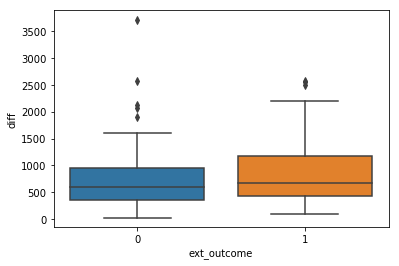

In [1040]:
ax = sns.boxplot(x=outcome_lab, y="diff", data=contDF)

* Mean for each category

In [1041]:
contDF.groupby(outcome_lab).agg({'diff': 'mean'})

,diff
ext_outcome,
0,766.672727
1,892.614035


* Median for each category

In [1042]:
contDF.groupby(outcome_lab).agg({'diff': 'median'})

,diff
ext_outcome,
0,591
1,680


* Histogram

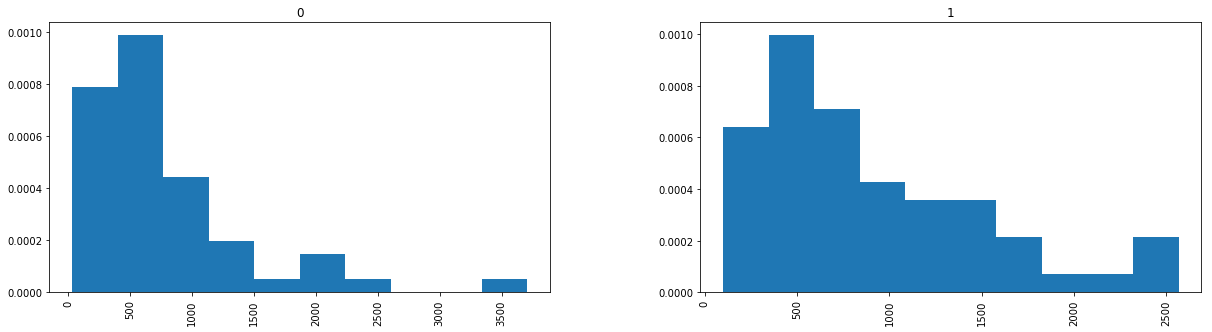

In [1043]:
axList=contDF['diff'].hist(by=contDF[outcome_lab],figsize=(20,5),bins=10,normed=True)

## Conclusions

This section collects all the conclusions derived from the first exploration of the data. It shows the variable that are relevant and irrelevant for the fate of the counter trades.<br>
* Relevant:<br>
1) RSI bounces <br>
Slightly higher in S trades<br>
Score+1 when >=4, score-1 otherwise<br>
2) No of candles <br>
Score+1 when No of candles>=10. Score-1 otherwise<br>
3) Entry on RSI <br>
Score-3 when TRUE<br>
4) Length of the trend <br>
When length is>=65 then score+1. score-1 otherwise<br>
5) Divergence <br>
Score+3 when TRUE<br>
6) sum_bounces <br>
Score+1 when >=7, score-1 otherwise<br>
7) Bounces <br>
Score +2 when >=3, score-2 otherwise<br>
8) Stretches-AVG angle <br>
Score +1 when <=30, score-1 otherwise<br>
9) Stretches-Number of stretches<br>
Score+2 if >=4, score-2 otherwise<br>
10) Stretches-Last stretch<br>
    Score+1 if <60, score-1 otherwise<br>
11) Diff<br>
Score+2 if >=680, score-2 otherwise<br>

* Irrelevant:<br>
1) indecission <br>

## Calculating points
This section will calculate a total score for each trade that will be used to predict the outcome.<br>

### Splitting the data into training and test sets
Let's split the data into training and test sets. We are going to use a test set size of 0.33

In [1044]:
train, test = train_test_split(contDF,
                               test_size=0.33
                              )

First, let's create a function to calculate the points

In [1045]:
def calculate_points(row,attribs):
    '''
    Function to calculate the points for a particular trade
    
    Parameters
    ----------
    row : dataframe row
    attribs : list of dicts
              The dict has the following format:
              {'attr' : 'RSI bounces',
               'cutoff' : 3,
               'points' : 2}
               
    Returns
    -------
    Returns a score for this trade
    
    '''
    score=0
    for a in attribs:
        value=row[a['attr']]
        cutoff=a['cutoff']
        points=a['points']
        if cutoff =='bool':
            if a['rel'] == 'is_true':
                if value == True or value == 1:
                    score+=points
                if value == False  or value == 0:
                    score+=-1*points
            if a['rel'] == 'is_true_oneway':
                if value == True or value == 1:
                    score+=points
        else:
            if a['rel'] == 'less':
                if value < cutoff: 
                    score+=points
                if value >= cutoff: 
                    score+=-1*points
            elif a['rel'] == 'range':
                p=re.compile("(\d+)-(\d+)")
                m=p.match(cutoff)
                upp=int(m.group(2))
                low=int(m.group(1))
                if value >=low and value <=upp:
                    score+=points
                else:
                    score+=-1*points
            elif a['rel'] == 'gt':
                if value >= cutoff: 
                    score+=points
                if value < cutoff: 
                    score+=-1*points
                
    return score

In [1046]:
attbs=[]

attbs.append({
        'attr' : 'RSI bounces',
        'cutoff' : 4,
        'rel' : 'gt',
        'points' : 1
        })
attbs.append({
        'attr' : 'No of candles',
        'cutoff' : 10,
        'rel' : 'gt',
        'points' : 1
        })
attbs.append({
        'attr' : 'entry on RSI',
        'cutoff' : 'bool',
        'rel' : 'is_true_oneway',
        'points' : -3
        })
attbs.append( {
        'attr' : 'length of trend',
        'cutoff' : 65,
        'rel' : 'gt',
        'points' : 1
        })
attbs.append( {
        'attr' : 'divergence',
        'cutoff' : 'bool',
        'rel' : 'is_true_oneway',
        'points' : 3
        })
attbs.append( {
        'attr' : 'sum_bounces',
        'cutoff' : 7,
        'rel' : 'gt',
        'points' : 1
        })
attbs.append( {
        'attr' : 'bounces',
        'cutoff' : 3,
        'rel' : 'gt',
        'points' : 2
        })
attbs.append( {
        'attr' : 'avg_angle',
        'cutoff' : 30,
        'rel' : 'less',
        'points' : 1
        })
attbs.append( {
        'attr' : 'no_stretches',
        'cutoff' : 4,
        'rel' : 'gt',
        'points' : 2
        })
attbs.append( {
        'attr' : 'last_stretch',
        'cutoff' : 60,
        'rel' : 'less',
        'points' : 1
        })
attbs.append( {
        'attr' : 'diff',
        'cutoff' : 680,
        'rel' : 'gt',
        'points' : 2
        })

Now, let's apply the calculate_points on each row for the training and the test set

In [1047]:
train['score']=train.apply(calculate_points, axis=1, attribs=attbs)
test['score']=test.apply(calculate_points, axis=1, attribs=attbs)

/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Calculating cutoff score
* Mean

In [1048]:
train.groupby(outcome_lab).agg({'score': 'mean'})

,score
ext_outcome,
0,-0.323529
1,3.243902


* Median

In [1049]:
train.groupby(outcome_lab).agg({'score': 'median'})

,score
ext_outcome,
0,0.5
1,3.0


* Histogram

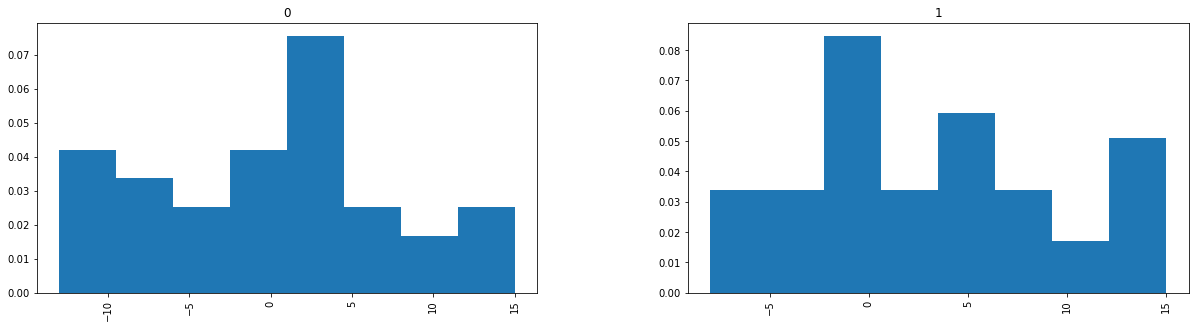

In [1050]:
axList=train['score'].hist(by=train[outcome_lab],figsize=(20,5),bins=8,normed=True)

### Making predictions and performance evaluation
We will use different cutoffs and make predictions using these using the test set

Let's create a new dataframe only with the columns we are interested in:

In [1051]:
scoreDF=test.iloc[:,[outcome_ix,24]]

In [1052]:
def predictOutcome(row, cutoff):
    pred=None
    if row['score'] >cutoff:
        pred=1
    else:
        pred=0
    return pred

In [1053]:
scoreDF['predict']=scoreDF.apply(predictOutcome,axis=1,cutoff=6.5)

/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


* Performance evaluation

In [1054]:
(tn, fp, fn, tp)=confusion_matrix(scoreDF['ext_outcome'], scoreDF['predict']).ravel()
print("TP:"+str(tp))
print("TN:"+str(tn))
print("FN:"+str(fn))
print("FP:"+str(fp))

TP:10
TN:19
FN:6
FP:2


    * Precision

In [1055]:
print(tp/(tp+fp))

0.833333333333


* Recall

In [1056]:
print(tp/(tp+fn))

0.625
